RGB to Haematoxylin-Eosin-DAB (HED) color space conversion followed by nuclei segmentation
and analysis

separate the immunohistochemical (IHC) staining from the hematoxylin counterstaining
The IHC staining expression of the FHL2 protein is here revealed with diaminobenzidine (DAB) which gives a brown color.

A. C. Ruifrok and D. A. Johnston, “Quantification of histochemical staining by color deconvolution,” Analytical and quantitative cytology and histology / the International Academy of Cytology [and] American Society of Cytology, vol. 23, no. 4, pp. 291-9, Aug. 2001. PMID: 11531144

https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py

Try WSI datasets from here
https://zenodo.org/record/1485967#.Yd31lv7MKbh
https://www.wouterbulten.nl/blog/tech/peso-dataset-whole-slide-image-prosate-cancer/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyclesperanto_prototype as cle

from skimage.io import imread, imsave, imshow
from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

from PIL import Image
from PIL import Image, ImageOps

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    
    ihc_hed = rgb2hed(ihc_rgb)
    
    # Create an RGB image for each of the separated stains
    # Convert them to ubyte for easy saving to drive as an image
    
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    # Optional fun exercise of combining H and DAB stains into a single image with fluorescence look
    
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))
   
    # Cast the two channels into an RGB image, as the blue and green channels
    # Convert to ubyte for easy saving as image to local drive
    
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

## Before I perform computations on an image, I like to look at the image within Jupyter
### We do not need to do this for every image, but it is a good idea to spot check your work as you go!

## Read-in your image:

In [3]:
# read in raw image
rgb = imread("11.jpg")

## View your image

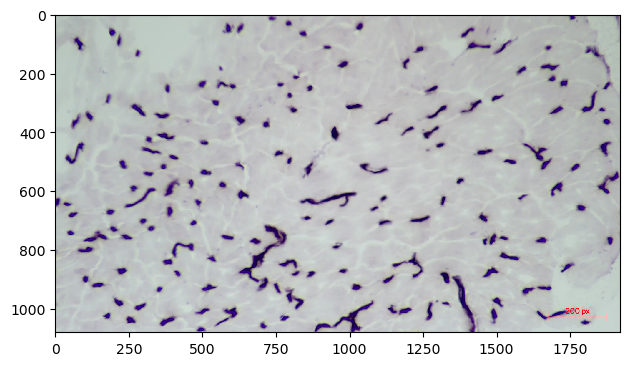

In [4]:
imshow(rgb)

## Look at the image shape.  
### This is another form of quality control to check on before performing calculations.

In [5]:
# image is 1080 pixels high, 1920 pixels wide, and has 3 channels.
y = rgb.shape
y

(1080, 1920, 3)

In [6]:
height_of_image = y[0]
height_of_image

1080

In [7]:
width_of_image = y[1]
width_of_image

1920

In [8]:
# This code calculates the total PIXEL area of the image.  We will use this later!
image_pixel_area = height_of_image * width_of_image
image_pixel_area

2073600

# ---------------------------------------------------------------------------------

# This is the process I follow to obtain area measurements off of a stained microscope image.

## 1. Read-in image

In [9]:
# read in raw image
rgb2 = imread("11.jpg")

## 2a. Convert the image from RGB to HED using skimage

In [10]:
# Convert the RGB image to HED using the prebuilt skimage method
hed = rgb2hed(rgb2)

In [11]:
# Create an RGB image for each of the separated stains
# Convert them to ubyte for easy saving to drive as an image
    
null = np.zeros_like(hed[:, :, 0])
h = img_as_ubyte(hed2rgb(np.stack((hed[:, :, 0], null, null), axis=-1)))


#e = img_as_ubyte(hed2rgb(np.stack((null, hed[:, :, 1], null), axis=-1)))
#d = img_as_ubyte(hed2rgb(np.stack((null, null, hed[:, :, 2]), axis=-1)))

In [12]:
h = rescale_intensity(hed[:, :, 0], out_range=(0, 1), in_range=(0, np.percentile(hed[:, :, 0], 99)))

#d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1), in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

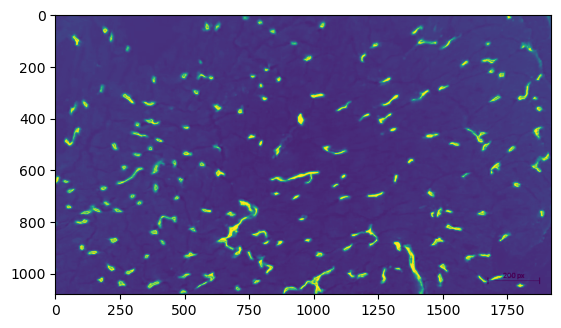

In [13]:
plt.imshow(h)

## 2b. Here is the way I more frequently convert an image to HED:

In [14]:
rgb3 = imread("11.jpg")

In [15]:
H,E,D,HD = color_separate(rgb3)

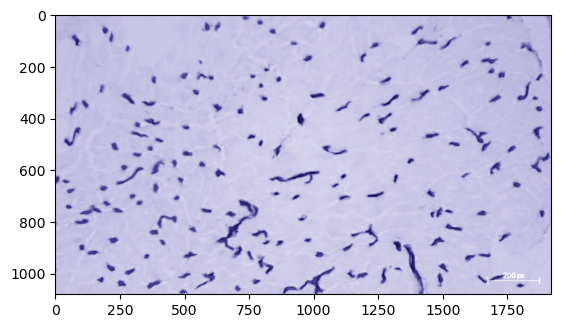

In [16]:
plt.imshow(H)

## 3. Invert the image.  
### We will be performing computations on the inverted image!

In [17]:
# Invert the image 
input_image = np.invert(H[:,:,2])

## 4. Normalize the image

In [18]:
norm_img = input_image / input_image.max()

## 5. View the inverted image

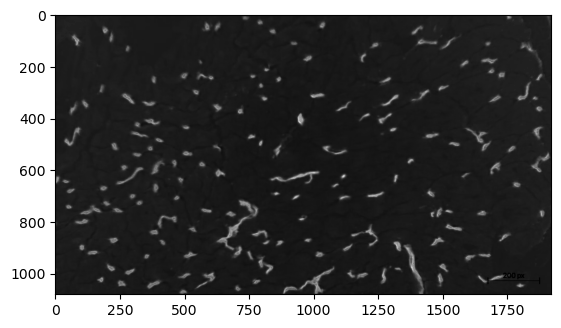

In [19]:
# View the image using a gray color map
plt.imshow(norm_img, cmap = 'gray')

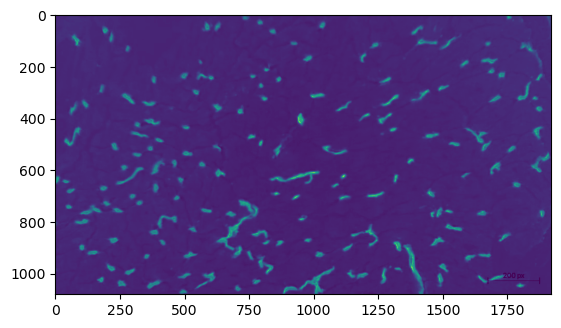

In [20]:
# View the original inverted image, no grayscale
plt.imshow(input_image)

### View the image again (sanity check) and save it for downstream analyses

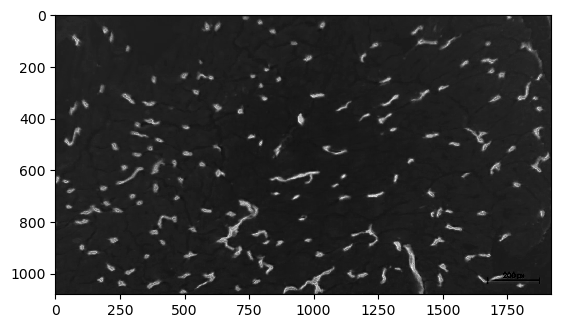

In [21]:
cle.imshow(input_image)
# Save your images
plt.imsave('H_img.jpg', input_image)

## 6. Segmentation using Voronoi-Otsu labeling

In [22]:
######################################################################################
# Segmentation using Voronoi-Otsu labeling                                           #
# For installation instructions of the package, please refer to the following link   #
# https://github.com/clEsperanto/pyclesperanto_prototype                             #
######################################################################################

In [41]:
# These variables are used to apply a mask to the stained image.  Play with these numbers under you 
# feel they represent what objects in the slide image you wish to measure.  I set both variables to 1, 
# the smallest amount they can set to.  This should be a very conservative approach.
sigma_spot_detection = 1
sigma_outline = 1

In [42]:
# Perform Voronoi-Otsu labeling
segmented = cle.voronoi_otsu_labeling(input_image, 
                                      spot_sigma = sigma_spot_detection, outline_sigma = sigma_outline)

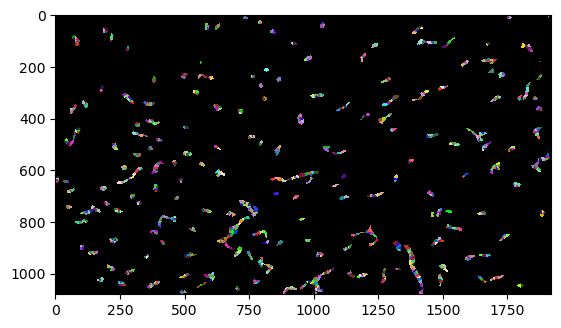

In [43]:
cle.imshow(segmented, labels = True)

## 7. Import image data into a Pandas dataframe

In [44]:
# Calculate the statistics of all labelled pixels
statistics = cle.statistics_of_labelled_pixels(input_image, segmented) 

In [27]:
# Save the statistics in a Pandas dataframe
stat_table = pd.DataFrame(statistics)  

In [28]:
# view summary statistics of the dataframe
print(stat_table.describe())

             label  original_label   bbox_min_x   bbox_min_y  bbox_min_z  \
count  1087.000000     1087.000000  1087.000000  1087.000000      1087.0   
mean    544.000000      544.000000   900.908020   651.083740         0.0   
std     313.934176      313.934176   551.107422   294.238983         0.0   
min       1.000000        1.000000     0.000000     0.000000         0.0   
25%     272.500000      272.500000   390.500000   437.000000         0.0   
50%     544.000000      544.000000   826.000000   696.000000         0.0   
75%     815.500000      815.500000  1402.000000   901.500000         0.0   
max    1087.000000     1087.000000  1909.000000  1072.000000         0.0   

        bbox_max_x   bbox_max_y  bbox_max_z   bbox_width  bbox_height  ...  \
count  1087.000000  1087.000000      1087.0  1087.000000  1087.000000  ...   
mean    911.771851   661.429626         0.0    11.863846    11.345906  ...   
std     551.751160   293.821960         0.0     3.569856     3.127133  ...   
min

In [29]:
# view the nuber of datapoints in each column

print(stat_table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   label                                   1087 non-null   int64  
 1   original_label                          1087 non-null   int64  
 2   bbox_min_x                              1087 non-null   float32
 3   bbox_min_y                              1087 non-null   float32
 4   bbox_min_z                              1087 non-null   float32
 5   bbox_max_x                              1087 non-null   float32
 6   bbox_max_y                              1087 non-null   float32
 7   bbox_max_z                              1087 non-null   float32
 8   bbox_width                              1087 non-null   float32
 9   bbox_height                             1087 non-null   float32
 10  bbox_depth                              1087 non-null   floa

In [30]:
# Create the pandas dataframe
stat_table.drop(columns = stat_table.columns[-10:], axis = 1,  inplace = True)
df = pd.DataFrame(stat_table)

In [31]:
# View the top 5 rows of data
df.head()

,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,mass_center_x,sum_intensity_times_y,mass_center_y,sum_intensity_times_z,mass_center_z,sum_x,centroid_x,sum_y,centroid_y,sum_z
0,1,1,0.0,642.0,0.0,4.0,652.0,0.0,5.0,11.0,...,1.177116,2480510.0,647.991089,0.0,0.0,41.0,1.242424,21391.0,648.212097,0.0
1,2,2,0.0,804.0,0.0,3.0,814.0,0.0,4.0,11.0,...,1.043644,2334091.0,808.483215,0.0,0.0,38.0,1.151515,26682.0,808.545471,0.0
2,3,3,0.0,983.0,0.0,2.0,991.0,0.0,3.0,9.0,...,0.729767,2159493.0,987.422485,0.0,0.0,20.0,0.869565,22708.0,987.304321,0.0
3,4,4,0.0,640.0,0.0,12.0,652.0,0.0,13.0,13.0,...,5.675639,6093154.0,645.666443,0.0,0.0,490.0,5.903615,53613.0,645.939758,0.0
4,5,5,0.0,635.0,0.0,15.0,646.0,0.0,16.0,12.0,...,8.055362,6427868.0,640.034668,0.0,0.0,707.0,8.126437,55689.0,640.103455,0.0


In [32]:
# Create a dataframe of the columns you wish to investigate further
stats = df[['label', 'area', 'min_intensity', 'max_intensity', 'mean_intensity']]

In [33]:
stats.head()

,label,area,min_intensity,max_intensity,mean_intensity
0,1,33.0,72.0,169.0,116.000000
1,2,33.0,68.0,121.0,87.484848
2,3,23.0,63.0,158.0,95.086960
3,4,83.0,65.0,166.0,113.698792
4,5,87.0,69.0,159.0,115.436783


In [34]:
# Calculate the sum of each column.  This should give us the total area stained
important_stats = stats.sum()
important_stats

label             591328.000000
area               92783.000000
min_intensity      72289.000000
max_intensity     171872.000000
mean_intensity    121214.539062
dtype: float64

In [35]:
# Save the total area stained to a variable:
stained_area = important_stats['area']
stained_area

92783.0

In [36]:
# Use the total pixel area calculate above:
total_pixel_area = image_pixel_area
total_pixel_area

2073600

In [37]:
# Calculate the percent of the area stained:
percent_area_stained = (stained_area / total_pixel_area) * 100
percent_area_stained

4.474488811728395